# IDEO Data Homework

## Exercise 1

### Data Cleaning and Exploration

Let's fetch the data first.

In [4]:
! mkdir ../data

In [20]:
! wget https://data.cityofchicago.org/api/views/5neh-572f/rows.csv?accessType=DOWNLOAD -O ../data/ridership.csv

--2018-02-06 11:50:22--  https://data.cityofchicago.org/api/views/5neh-572f/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘../data/ridership.csv’

    [                                    <=>] 32,379,971   574KB/s   in 58s    

Last-modified header invalid -- time-stamp ignored.
2018-02-06 11:51:20 (547 KB/s) - ‘../data/ridership.csv’ saved [32379971]



Let's have a look and make sure we understand what's in the data:

In [557]:
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)

In [558]:
! wc -l ../data/ridership.csv

879577 ../data/ridership.csv


In [559]:
df = pd.read_csv('../data/ridership.csv')

In [560]:
df.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,01/01/2001,U,290
1,40020,Harlem-Lake,01/01/2001,U,633
2,40030,Pulaski-Lake,01/01/2001,U,483
3,40040,Quincy/Wells,01/01/2001,U,374
4,40050,Davis,01/01/2001,U,804


In [561]:
# invoke some Pandas magic for date parsing
df['date'] = pd.to_datetime(df.date)

In [562]:
df.shape

(879576, 5)

The data format looks pretty straightforward. 

Let's do some housekeeping first though, and ensure that the data doesn't display any obvious inconsistencies.

#### Uniqueness in names and IDs

In [563]:
# number of unique stationname
df.stationname.nunique()

148

In [564]:
# number of unique station_id
df.station_id.nunique()

147

In [565]:
# number of unique (station_id, stationname)
df.drop_duplicates(['station_id','stationname']).shape

(148, 5)

So a `station_id` is non-unique. Let's check:

In [566]:
df.drop_duplicates(['station_id','stationname'])\
  .groupby('station_id')\
  .stationname.count()\
  .sort_values().tail(1)

station_id
40140    2
Name: stationname, dtype: int64

In [567]:
df[df.station_id==40140].stationname.unique()

array(['Skokie', 'Dempster-Skokie'], dtype=object)

Ok, so 'Skokie' and 'Dempster-Skokie' share a `station_id`. Could be a renaming issue:

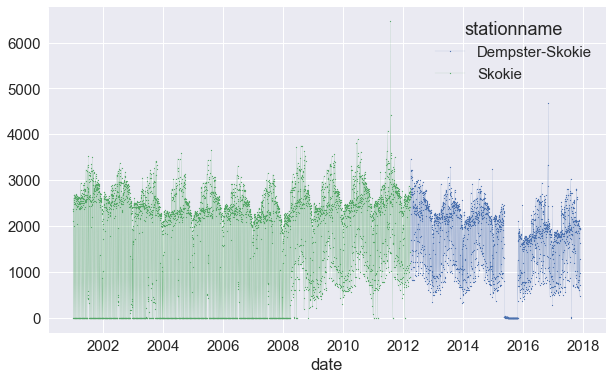

In [568]:
df.loc[df.station_id==40140,['stationname','date','rides']]\
    .groupby(['stationname','date'])\
    .sum().rides.unstack().T.plot(figsize=(10,6), marker='.', linewidth=.1, markersize=2.5)

In [569]:
df.loc[df.stationname=='Skokie'].date.max()

Timestamp('2012-03-31 00:00:00')

In [570]:
df.loc[df.stationname=='Dempster-Skokie'].date.min()

Timestamp('2012-04-01 00:00:00')

Indeed! Given that the station is now called 'Dempster-Skokie', let's retroactively name it to that:

In [571]:
df.loc[df.stationname=='Skokie','stationname'] = 'Dempster-Skokie'

In [572]:
# now there are as many IDs as names
df.drop_duplicates(['station_id','stationname']).shape

(147, 5)

#### Uniqueness in IDs and Dates
We expect this data to be aggregated by station and date. Let's make sure we don't see duplicate dates:

In [573]:
df.groupby(['station_id','date']).size().sort_values().value_counts()

1    878340
2       618
dtype: int64

Of course it's not quite clean `:/`

Let's investigate those 618 `(station_id, date)` pairs that have multiple rows:

In [574]:
doubledates = df.groupby(['station_id','date']).size().sort_values()

In [575]:
doubledates = df.set_index(['station_id','date']).loc[doubledates[doubledates>1].index].sort_index()
doubledates.head()

stationname daytype  rides
station_id date                                         
40010      2011-07-18  Austin-Forest Park       W   2017
           2011-07-18  Austin-Forest Park       W   2021
           2011-07-25  Austin-Forest Park       W   2007
           2011-07-25  Austin-Forest Park       W   2015
           2011-08-01  Austin-Forest Park       W   2000

In [576]:
doubledates.tail()

stationname daytype  rides
station_id date                                     
41500      2011-08-10  Montrose-Brown       W   2528
41660      2011-07-23      Lake/State       A  12439
           2011-07-23      Lake/State       A  12440
           2011-08-07      Lake/State       U   9193
           2011-08-07      Lake/State       U   9215

Curious. It looks like the duplicate values are close together. Let's check, in terms of percentages of the larger number:

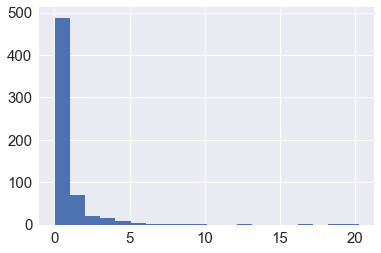

In [577]:
percentage_errors = doubledates.groupby(level=[0,1]).rides\
    .apply(lambda x: 100.*(max(x)-min(x))/max(x))
    
percentage_errors.hist(bins=20)

Those minor differences of a few percents don't worry me too much, but there are a handful of >10% errors in the data. 

In [578]:
percentage_errors.sort_values(ascending=False).head(15)

station_id  date      
41460       2011-07-20    20.271210
40600       2011-07-20    18.789144
40590       2011-07-30    17.038818
40540       2011-07-31    12.357414
41250       2011-08-06     9.572650
40440       2011-07-28     8.841010
40720       2011-08-08     8.801625
41260       2011-07-29     7.859209
40590       2011-07-24     7.740162
41360       2011-07-21     7.172996
40590       2011-07-28     7.087253
40540       2011-08-06     5.802441
41050       2011-08-01     5.610973
40920       2011-07-29     5.245536
41190       2011-08-09     5.144928
Name: rides, dtype: float64

How curious, Dr Watson! This all happened in late July and early August of 2011. In real life, this would be a good data issue to discuss with the project partner who owns the data systems. Most likely, either a shift in data recording standards or a systems migration happened in summer 2011. (I have found a [presentation](https://www.transit.dot.gov/sites/fta.dot.gov/files/docs/CTAs_Plans_for_Condition_Assessment_Process_Improvement-Leah_Dawson.pdf) that mentions a database migration planned for that period, but it's for the CTA's asset management system, which I would guess is entirely separate). For the purpose of this exercise, we'll take the mean (our best guess, basically), and round it so we're still dealing with integers.

In [579]:
df = df.groupby(['station_id','stationname','date','daytype'])\
       .mean().round().astype(int)\
       .reset_index()

In [580]:
df.shape

(878958, 5)

We've lost the duplicate `(station_id, date)` rows.

#### Ranges of `daytype`, `date`, and `rides`

We still need to sanity-check some date ranges and counts, to make sure we don't see any negative values or missing date, for example:

In [581]:
df.date.describe()

count                  878958
unique                   6178
top       2017-11-28 00:00:00
freq                      145
first     2001-01-01 00:00:00
last      2017-11-30 00:00:00
Name: date, dtype: object

In [582]:
df.daytype.value_counts(dropna=False)

W    614193
U    139845
A    124920
Name: daytype, dtype: int64

In [583]:
df.isnull().sum()

station_id     0
stationname    0
date           0
daytype        0
rides          0
dtype: int64

I'm happy with these so far; they seem plausible.

In [584]:
df.rides.describe()

count    878958.000000
mean       3306.342493
std        3184.991488
min           0.000000
25%        1122.000000
50%        2318.000000
75%        4350.000000
max       36323.000000
Name: rides, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f401512f9e8>]],
      dtype=object)

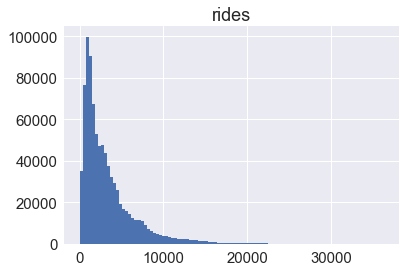

In [585]:
df[['rides']].hist(bins=100)

That looks good, but there is a lot of 0s. That could point to missing data. Let's make sure we have data coverage for stations across time.

#### Date coverage per station

First, let's look which stations have the most days with 0 riders:

In [586]:
(df.set_index('station_id').rides == 0)\
    .groupby('station_id')\
    .sum()\
    .sort_values(ascending=False)\
    .head(10)

station_id
40640    1010.0
40140     867.0
40500     730.0
41210     484.0
40090     388.0
41460     368.0
41310     368.0
40360     361.0
41440     361.0
41500     356.0
Name: rides, dtype: float64

In itself, that's not worrying - maybe they're just not too busy (though 1010 days of not being busy seems entirely unlikely). To make it more specific, let's search for consecutive stretches of days with 0 riders. This is a little cumbersome, but `itertools` to the rescue:

In [587]:
import itertools

df = df.sort_values(by=['station_id','date'])

def zero_grouper(x):
    """ Return the longest stretch of 0's in the iterable x.
        Follows the example on 
        https://stackoverflow.com/questions/22214086/python-a-program-to-find-the-length-of-the-longest-run-in-a-given-list
    """
    
    try:
        # max throws a ValueError if there are no 0s in x
        return max( sum(1 for x in l) for n, l in itertools.groupby(x) if n==0 )
    except ValueError:
        # ... in which case the longest 0-sequence has length 0
        return 0

In [588]:
long_zero_stations = df.groupby('stationname').rides.apply(zero_grouper)\
  .sort_values(ascending=False)
    
long_zero_stations.head(15)

stationname
Wellington           484
Damen-Brown          388
Irving Park-Brown    368
Paulina              368
Madison/Wabash       364
Southport            361
Addison-Brown        358
Montrose-Brown       352
Washington/State     339
Diversey             277
Kedzie-Brown         174
Rockwell             172
Francisco            170
95th/Dan Ryan        123
87th                 123
Name: rides, dtype: int64

So these are somewhat problematic stations. Let's look at them.

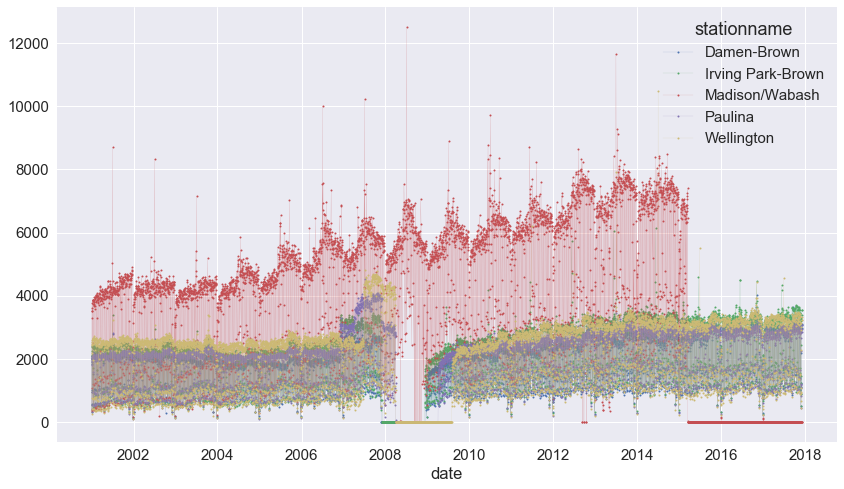

In [589]:
df[df.stationname.isin(long_zero_stations.head(5).index)]\
    .set_index(['stationname', 'date'])\
    .rides.unstack().T\
    .plot(figsize=(14,8), marker='o', linewidth=0.1, markersize=2)

Clearly, there are some data issues here. It seems that the Madison/Wasbash stop, for example, was [shut down in mid-2015](https://en.wikipedia.org/wiki/Madison/Wabash_station). And Wellington station was <a href="https://en.wikipedia.org/wiki/Wellington_station_(CTA)">losed for over a year for renovations</a>.

When calculating means and standard deviations across stations, we're most likely interested in rider averages due to 'natural' fluctuations, not due to station closures. Thus, we have to to detect (temporary) closures, and remove these rows from our dataset; otherwise, we're biasing our estimates.

For this warm-up, we'll proceed while leaving the data as-is. In other words, we'll incorporate low ridership due to closures, renovation, and the like into our estimates.

### 1. Which stop has the highest average ridership per day, and what is it?

Given that we know each station to occur only once for each day, we can do this quickly:

In [590]:
df.groupby('stationname').rides.mean().sort_values(ascending=False).head(1)

stationname
Clark/Lake    13831.326805
Name: rides, dtype: float64

This make sense: Clark/Lake is a busy station, and sees about 14k riders/day.

### 2. Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it?

The dataset comes with a friendly indicator (`W`) for weekdays:

In [591]:
df[df.daytype=='W'].groupby('stationname').rides.std().sort_values(ascending=False).head(1)

stationname
Washington/Wabash    4444.285216
Name: rides, dtype: float64

The highest standard deviation occurs at Washington/Wabash with about 4400 riders per day. This is interesting, because Washington/Wabash is a very new station. Let's look a little closer:

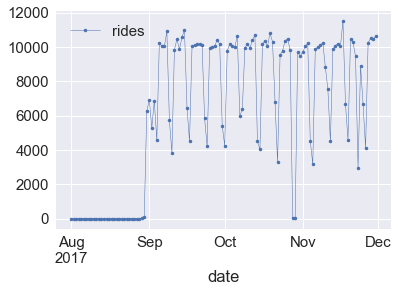

In [592]:
df[df.stationname=='Washington/Wabash'].set_index('date')[['rides']]\
    .plot(marker='o', markersize=3.5, linewidth=0.5)

The high standard deviation is caused partially by the data recording format: The station opened only on August 31st, but data was already recorded through August. Note that this is exactly the issue with temporary station closures (in this case, delayed openings) mentioned above. Compare the above graph with the second-highest standard deviation:

In [593]:
df[df.daytype=='W'].groupby('stationname').rides.std().sort_values(ascending=False).index[1]

'Lake/State'

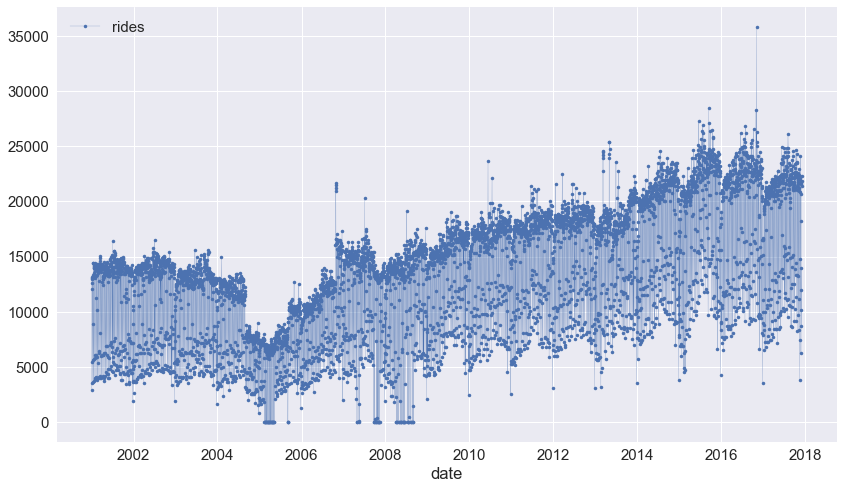

In [594]:
df[df.stationname=='Lake/State'].set_index('date')[['rides']]\
    .plot(figsize=(14,8), marker='o', markersize=3.5, linewidth=0.2)

Lake/State is a busy station with years of data, and no apparent data issues.

## Save the data
We've done some cleaning, so let's save this data for later:

In [ ]:
df.to_csv('../data/clean.csv', index=False)